<h1> Realistic Botnet Traffic Generation using GANs </h1><br>
Rizwan Hamid Randhawa<br>
Development Notebook
<hr>

This notebook is for a conference publication <hr>


<a id="TOC"></a><h2>Table of Contents</h2>
<br>
<a href='#Setup'> Setup</a><br>
<br>
<a href='#EDA'> Preprocessing </a><br>
<a href='#xgboost botnet detection'> Botnet Detection</a><br>
<a href='#Classification'> Subclass clustering </a><br>
<br>
<a href="#GAN setup"> GAN setup and training</a><br>
<br>
<a href="#Compare GAN Output"> Compare GAN Output</a><br>
<a href="#Generated Data Testing"> Generated Data Testing</a><br>
<a href="#Summary"> Summary of Training Data</a><br>
<br>


<a id="Setup"><h1>Setup</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Load libraries
- Load common functions
- Load stored datasets
- Use linux for xgboost and tensorflow

In [1]:
MAIN_CODE_PATH = '/home/riz/Work/Development/code-in-prog/project-folder'
DATA_SET_PATH = '/home/riz/Work/Development/code-in-prog/Data_set/'

In [2]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

   
import numpy as np
import pandas as pd

from scipy import stats



# from tensorflow.keras import backend
from tensorflow.python.keras import backend


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()


# Load custom functions

import gan

# For reloading after making changes
import importlib
importlib.reload(gan) 
from gan import *

import pandas as pd

import timeit
# code you want to evaluate

%cd $DATA_SET_PATH
!ls

begin_from_start = 0

take_chunk = 0


/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/riz/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

/home/riz/Work/Development/code-in-prog/Data_set
botnet.data.csv
botnet.testing_data.csv
check_data.csv
class_labels.csv
creditcard.csv
credit_card_data
data.csv
DATA.csv
Friday-WorkingHours.pcap_Flow.csv
Friday-WorkingHours.pcap_Flow.pkl
gen_data_set.csv
ISCX_Botnet-Testing.pcap_Flow.csv
ISCX_Botnet-Training.pcap_Flow.csv
ISCX_Botnet-Training-time-correction-done.pcap_Flow.csv
testing_data.csv
testing_DATA.csv


Using TensorFlow backend.


In [3]:
if begin_from_start:

    data = pd.read_csv (r'ISCX_Botnet-Training.pcap_Flow.csv', low_memory=False)
    # data = data[0:50000] 
    
    

    print(data.shape)

In [4]:
if begin_from_start:
    testing_data = pd.read_csv (r'ISCX_Botnet-Testing.pcap_Flow.csv', low_memory=False)
    # data = data[0:50000] 

    print(testing_data.shape)

In [5]:
if begin_from_start:

    botnet = True
    z_score = False

In [6]:
if begin_from_start:

    #replace inf with nan and then drop the rows with nans
    print("Null Values in data set: " + str(data.isnull().sum().sum()) )

    print(data.shape)

    data = data.replace([np.inf, -np.inf], np.nan).dropna(how="any").reset_index(drop=True)

    print("Null Values in data set: " + str(data.isnull().sum().sum()) )


    print(data.shape)

In [7]:
if begin_from_start:

    #replace inf with nan and then drop the rows with nans
    print("Null Values in data set: " + str(testing_data.isnull().sum().sum()) )

    print(testing_data.shape)

    testing_data = testing_data.replace([np.inf, -np.inf], np.nan).dropna(how="any").reset_index(drop=True)

    print("Null Values in data set: " + str(testing_data.isnull().sum().sum()) )


    print(testing_data.shape)

In [8]:
if begin_from_start:

    # data columns will be all the columns except Src IP, Src Port, Dsp IP, Dst Port
    # and Timestamp as we are not considering categorical and time stamp features.

    # data= data.drop(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Protocol', \
    #                  'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', \
    #                  'CWE Flag Count', 'ECE Flag Cnt'], axis=1)
    if botnet == True: 
    #     data= data.drop(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Protocol', 'Init Fwd Win Byts'], axis=1)
        data= data.drop(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Protocol'], axis=1)


        print(data.shape)

        #In this cell we will find the indices in flows that will show the flows for the particular botnet


        df = data[['Flow ID', 'Label']]

        IRC_1 = df['Flow ID'].str.contains('192.168.2.112-131.202.243.84')
        IRC_2 = df['Flow ID'].str.contains('192.168.5.122-198.164.30.2')
        IRC_3 = df['Flow ID'].str.contains('192.168.2.110-192.168.5.122')
        IRC_4 = df['Flow ID'].str.contains('192.168.4.118-192.168.5.122')
        IRC_5 = df['Flow ID'].str.contains('192.168.2.113-192.168.5.122')
        IRC_6 = df['Flow ID'].str.contains('192.168.1.103-192.168.5.122')
        IRC_7 = df['Flow ID'].str.contains('192.168.4.120-192.168.5.122')
        IRC_8 = df['Flow ID'].str.contains('192.168.2.112-192.168.2.110')
        IRC_9 = df['Flow ID'].str.contains('192.168.2.112-192.168.4.120')
        IRC_10 = df['Flow ID'].str.contains('192.168.2.112-192.168.1.103')
        IRC_11 = df['Flow ID'].str.contains('192.168.2.112-192.168.2.113')
        IRC_12 = df['Flow ID'].str.contains('192.168.2.112-192.168.4.118')
        IRC_13 = df['Flow ID'].str.contains('192.168.2.112-192.168.2.109')
        IRC_14 = df['Flow ID'].str.contains('192.168.2.112-192.168.2.105')
        IRC_15 = df['Flow ID'].str.contains('192.168.1.105-192.168.5.122')


        Neris = df['Flow ID'].str.contains('147.32.84.180')
        RBot  = df['Flow ID'].str.contains('147.32.84.170')
        Menti = df['Flow ID'].str.contains('147.32.84.150')
        Sogou = df['Flow ID'].str.contains('147.32.84.140')
        Murlo = df['Flow ID'].str.contains('147.32.84.130')
        Virut = df['Flow ID'].str.contains('147.32.84.160')
        IRCbot_and_black_hole_1 = df['Flow ID'].str.contains('10.0.2.15')
        Black_hole_2 = df['Flow ID'].str.contains('192.168.106.141')
        Black_hole_3 = df['Flow ID'].str.contains('192.168.106.131')
        TBot_1 = df['Flow ID'].str.contains('172.16.253.130')
        TBot_2 = df['Flow ID'].str.contains('172.16.253.131')
        TBot_3 = df['Flow ID'].str.contains('172.16.253.129')
        TBot_4 = df['Flow ID'].str.contains('172.16.253.240')
        Weasel_master = df['Flow ID'].str.contains('74.78.117.238')
        Weasel_bot = df['Flow ID'].str.contains('158.65.110.24')
        Zeus_1  = df['Flow ID'].str.contains('192.168.3.35')
        Zeus_2 = df['Flow ID'].str.contains('192.168.3.25')
        Zeus_3 = df['Flow ID'].str.contains('192.168.3.65')
        bin_Zeus = df['Flow ID'].str.contains('172.29.0.116')
        Osx_trojan = df['Flow ID'].str.contains('172.29.0.109')
        zero_access_1 = df['Flow ID'].str.contains('172.16.253.132')
        zero_access_2 = df['Flow ID'].str.contains('192.168.248.165')
        Smoke_bot = df['Flow ID'].str.contains('10.37.130.4')





        indx_IRC_1 = [i for i, x in enumerate(IRC_1) if x]
        indx_IRC_2 = [i for i, x in enumerate(IRC_2) if x]
        indx_IRC_3 = [i for i, x in enumerate(IRC_3) if x]
        indx_IRC_4 = [i for i, x in enumerate(IRC_4) if x]
        indx_IRC_5 = [i for i, x in enumerate(IRC_5) if x]
        indx_IRC_6 = [i for i, x in enumerate(IRC_6) if x]
        indx_IRC_7 = [i for i, x in enumerate(IRC_7) if x]
        indx_IRC_8 = [i for i, x in enumerate(IRC_8) if x]
        indx_IRC_9 = [i for i, x in enumerate(IRC_9) if x]
        indx_IRC_10 = [i for i, x in enumerate(IRC_10) if x]
        indx_IRC_11 = [i for i, x in enumerate(IRC_11) if x]
        indx_IRC_12 = [i for i, x in enumerate(IRC_12) if x]
        indx_IRC_13 = [i for i, x in enumerate(IRC_13) if x]
        indx_IRC_14 = [i for i, x in enumerate(IRC_14) if x]
        indx_IRC_15 = [i for i, x in enumerate(IRC_15) if x]


        indx_Neris = [i for i, x in enumerate(Neris) if x]
        indx_RBot  = [i for i, x in enumerate(RBot) if x]
        indx_Menti = [i for i, x in enumerate(Menti) if x]
        indx_Sogou = [i for i, x in enumerate(Sogou) if x]
        indx_Murlo = [i for i, x in enumerate(Murlo) if x]
        indx_Virut = [i for i, x in enumerate(Virut) if x]
        indx_IRCbot_and_black_hole_1 = [i for i, x in enumerate(IRCbot_and_black_hole_1) if x]
        indx_Black_hole_2 = [i for i, x in enumerate(Black_hole_2) if x]
        indx_Black_hole_3 = [i for i, x in enumerate(Black_hole_3) if x]
        indx_TBot_1 = [i for i, x in enumerate(TBot_1) if x]
        indx_TBot_2 = [i for i, x in enumerate(TBot_2) if x]
        indx_TBot_3 = [i for i, x in enumerate(TBot_3) if x]
        indx_TBot_4 = [i for i, x in enumerate(TBot_4) if x]
        indx_Weasel_master = [i for i, x in enumerate(Weasel_master) if x]
        indx_Weasel_bot = [i for i, x in enumerate(Weasel_bot) if x]
        indx_Zeus_1  = [i for i, x in enumerate(Zeus_1) if x]
        indx_Zeus_2 = [i for i, x in enumerate(Zeus_2) if x]
        indx_Zeus_3 = [i for i, x in enumerate(Zeus_3) if x]
        indx_bin_Zeus = [i for i, x in enumerate(bin_Zeus) if x]
        indx_Osx_trojan = [i for i, x in enumerate(Osx_trojan) if x]
        indx_zero_access_1 = [i for i, x in enumerate(zero_access_1) if x]
        indx_zero_access_2 = [i for i, x in enumerate(zero_access_2) if x]
        indx_Smoke_bot = [i for i, x in enumerate(Smoke_bot) if x]
        indx_zero_access_1 = [i for i, x in enumerate(zero_access_1) if x]
        indx_zero_access_2 = [i for i, x in enumerate(zero_access_2) if x]
        indx_Smoke_bot = [i for i, x in enumerate(Smoke_bot) if x]


        total_instances = df.shape[0]
        print("Total Instances:" + str(total_instances))

        print("bin_IRC_1_Instances:" + str(len(indx_IRC_1))+ " ---> "+ str(round(len(indx_IRC_1)/total_instances*100, 2)) + " %")
        print("bin_IRC_2_Instances:" + str(len(indx_IRC_2))+ " ---> "+ str(round(len(indx_IRC_2)/total_instances*100, 2)) + " %")
        print("bin_IRC_3_Instances:" + str(len(indx_IRC_3))+ " ---> "+ str(round(len(indx_IRC_3)/total_instances*100, 2)) + " %")
        print("bin_IRC_4_Instances:" + str(len(indx_IRC_4))+ " ---> "+ str(round(len(indx_IRC_4)/total_instances*100, 2)) + " %")
        print("bin_IRC_5_Instances:" + str(len(indx_IRC_5))+ " ---> "+ str(round(len(indx_IRC_5)/total_instances*100, 2)) + " %")
        print("bin_IRC_6_Instances:" + str(len(indx_IRC_6))+ " ---> "+ str(round(len(indx_IRC_6)/total_instances*100, 2)) + " %")
        print("bin_IRC_7_Instances:" + str(len(indx_IRC_7))+ " ---> "+ str(round(len(indx_IRC_7)/total_instances*100, 2)) + " %")
        print("bin_IRC_8_Instances:" + str(len(indx_IRC_8))+ " ---> "+ str(round(len(indx_IRC_8)/total_instances*100, 2)) + " %")
        print("bin_IRC_9_Instances:" + str(len(indx_IRC_9))+ " ---> "+ str(round(len(indx_IRC_9)/total_instances*100, 2)) + " %")
        print("bin_IRC_10_Instances:" + str(len(indx_IRC_10))+ " ---> "+ str(round(len(indx_IRC_10)/total_instances*100, 2)) + " %")
        print("bin_IRC_11_Instances:" + str(len(indx_IRC_11))+ " ---> "+ str(round(len(indx_IRC_11)/total_instances*100, 2)) + " %")
        print("bin_IRC_12_Instances:" + str(len(indx_IRC_12))+ " ---> "+ str(round(len(indx_IRC_12)/total_instances*100, 2)) + " %")
        print("bin_IRC_13_Instances:" + str(len(indx_IRC_13))+ " ---> "+ str(round(len(indx_IRC_13)/total_instances*100, 2)) + " %")
        print("bin_IRC_14_Instances:" + str(len(indx_IRC_14))+ " ---> "+ str(round(len(indx_IRC_14)/total_instances*100, 2)) + " %")
        print("bin_IRC_15_Instances:" + str(len(indx_IRC_15))+ " ---> "+ str(round(len(indx_IRC_15)/total_instances*100, 2)) + " %")



        print("Neris_Instances:" + str(len(indx_Neris)) + " ---> "+ str(round(len(indx_Neris)/total_instances*100, 2)) + " %")
        print("RBot_Instances:" + str(len(indx_RBot)) + " ---> "+ str(round(len(indx_RBot)/total_instances*100, 2)) + " %")
        print("Menti_Instances:" + str(len(indx_Menti)) + " ---> "+ str(round(len(indx_Menti)/total_instances*100, 2)) + " %")
        print("Sogou_Instances:" + str(len(indx_Sogou)) + " ---> "+ str(round(len(indx_Sogou)/total_instances*100, 2)) + " %")
        print("Murlo_Instances:" + str(len(indx_Murlo)) + " ---> "+ str(round(len(indx_Murlo)/total_instances*100, 2)) + " %")
        print("Virut_Instances:" + str(len(indx_Virut)) + " ---> "+ str(round(len(indx_Virut)/total_instances*100, 2)) + " %")
        print("IRCbot_and_black_hole_1_Instances:" + str(len(indx_IRCbot_and_black_hole_1)) + " ---> "+ str(round(len(indx_IRCbot_and_black_hole_1)/total_instances*100, 2)) + " %")
        print("Black_hole_2_Instances:" + str(len(indx_Black_hole_2)) + " ---> "+ str(round(len(indx_Black_hole_2)/total_instances*100, 2)) + " %")
        print("Black_hole_3_Instances:" + str(len(indx_Black_hole_3)) + " ---> "+ str(round(len(indx_Black_hole_3)/total_instances*100, 2)) + " %")
        print("TBot_1_Instances:" + str(len(indx_TBot_1)) + " ---> "+ str(round(len(indx_TBot_1)/total_instances*100, 2)) + " %")
        print("TBot_2_Instances:" + str(len(indx_TBot_2)) + " ---> "+ str(round(len(indx_TBot_2)/total_instances*100, 2)) + " %")
        print("TBot_3_Instances:" + str(len(indx_TBot_3)) + " ---> "+ str(round(len(indx_TBot_3)/total_instances*100, 2)) + " %")
        print("TBot_4_Instances:" + str(len(indx_TBot_4)) + " ---> "+ str(round(len(indx_TBot_4)/total_instances*100, 2)) + " %")
        print("Weasel_master_Instances:" + str(len(indx_Weasel_master)) + " ---> "+ str(round(len(indx_Weasel_master)/total_instances*100, 2)) + " %")
        print("Weasel_bot_Instances:" + str(len(indx_Weasel_bot)) + " ---> "+ str(round(len(indx_Weasel_bot)/total_instances*100, 2)) + " %")
        print("Zeus_1_Instances:" + str(len(indx_Zeus_1)) + " ---> "+ str(round(len(indx_Zeus_1)/total_instances*100, 2)) + " %")
        print("Zeus_2_Instances:" + str(len(indx_Zeus_2)) + " ---> "+ str(round(round(len(indx_Zeus_2)/total_instances*100, 2), 2)) + " %")
        print("Zeus_3_Instances:" + str(len(indx_Zeus_3)) + " ---> "+ str(round(len(indx_Zeus_3)/total_instances*100, 2)) + " %")
        print("bin_Zeus_Instances:" + str(len(indx_Zeus_3)) + " ---> "+ str(round(len(indx_Zeus_3)/total_instances*100, 2)) + " %")
        print("Osx_trojan_Instances:" + str(len(indx_Osx_trojan)) + " ---> "+ str(round(len(indx_Osx_trojan)/total_instances*100, 2)) + " %")
        print("zero_access_1_Instances:" + str(len(indx_zero_access_1)) + " ---> "+ str(round(len(indx_zero_access_1)/total_instances*100, 2)) + " %")
        print("zero_access_2_Instances:" + str(len(indx_zero_access_2)) + " ---> "+ str(round(len(indx_zero_access_2)/total_instances*100, 2)) + " %")
        print("Smoke_bot_Instances:" + str(len(indx_Smoke_bot)) + " ---> "+ str(round(len(indx_Smoke_bot)/total_instances*100, 2)) + " %")


In [9]:
%%time
if begin_from_start:

    if botnet == True:

        # This cell labels the 'Label' column in the data frame to 1 where the particular botnet was found

        data.loc[:, 'Label'] = 0.0

        data.loc[indx_IRC_2, 'Label'] = 1
        data.loc[indx_IRC_3, 'Label'] = 1
        data.loc[indx_IRC_4, 'Label'] = 1
        data.loc[indx_IRC_5, 'Label'] = 1
        data.loc[indx_IRC_6, 'Label'] = 1
        data.loc[indx_IRC_7, 'Label'] = 1
        data.loc[indx_IRC_11, 'Label'] = 1
        data.loc[indx_IRC_15, 'Label'] = 1
        data.loc[indx_Neris, 'Label'] = 1

        data.loc[indx_RBot, 'Label'] = 1

        data.loc[indx_Virut, 'Label'] = 1

        data.loc[indx_Zeus_2, 'Label'] = 1


    #     print(data['Label'])

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs


In [10]:
if begin_from_start:

    # data columns will be all the columns except Src IP, Src Port, Dsp IP, Dst Port
    # and Timestamp as we are not considering categorical and time stamp features.

    # data= data.drop(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Protocol', \
    #                  'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', \
    #                  'CWE Flag Count', 'ECE Flag Cnt'], axis=1)
    if botnet == True: 
    #     data= data.drop(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Protocol', 'Init Fwd Win Byts'], axis=1)
        testing_data= testing_data.drop(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Protocol'], axis=1)


        print(testing_data.shape)

        #In this cell we will find the indices in flows that will show the flows for the particular botnet

        testing_df = testing_data[['Flow ID', 'Label']]

        IRC_1 = testing_df['Flow ID'].str.contains('192.168.2.112-131.202.243.84')
        IRC_2 = testing_df['Flow ID'].str.contains('192.168.5.122-198.164.30.2')
        IRC_3 = testing_df['Flow ID'].str.contains('192.168.2.110-192.168.5.122')
        IRC_4 = testing_df['Flow ID'].str.contains('192.168.4.118-192.168.5.122')
        IRC_5 = testing_df['Flow ID'].str.contains('192.168.2.113-192.168.5.122')
        IRC_6 = testing_df['Flow ID'].str.contains('192.168.1.103-192.168.5.122')
        IRC_7 = testing_df['Flow ID'].str.contains('192.168.4.120-192.168.5.122')
        IRC_8 = testing_df['Flow ID'].str.contains('192.168.2.112-192.168.2.110')
        IRC_9 = testing_df['Flow ID'].str.contains('192.168.2.112-192.168.4.120')
        IRC_10 = testing_df['Flow ID'].str.contains('192.168.2.112-192.168.1.103')
        IRC_11 = testing_df['Flow ID'].str.contains('192.168.2.112-192.168.2.113')
        IRC_12 = testing_df['Flow ID'].str.contains('192.168.2.112-192.168.4.118')
        IRC_13 = testing_df['Flow ID'].str.contains('192.168.2.112-192.168.2.109')
        IRC_14 = testing_df['Flow ID'].str.contains('192.168.2.112-192.168.2.105')
        IRC_15 = testing_df['Flow ID'].str.contains('192.168.1.105-192.168.5.122')


        Neris = testing_df['Flow ID'].str.contains('147.32.84.180')
        RBot  = testing_df['Flow ID'].str.contains('147.32.84.170')
        Menti = testing_df['Flow ID'].str.contains('147.32.84.150')
        Sogou = testing_df['Flow ID'].str.contains('147.32.84.140')
        Murlo = testing_df['Flow ID'].str.contains('147.32.84.130')
        Virut = testing_df['Flow ID'].str.contains('147.32.84.160')
        IRCbot_and_black_hole_1 = testing_df['Flow ID'].str.contains('10.0.2.15')
        Black_hole_2 = testing_df['Flow ID'].str.contains('192.168.106.141')
        Black_hole_3 = testing_df['Flow ID'].str.contains('192.168.106.131')
        TBot_1 = testing_df['Flow ID'].str.contains('172.16.253.130')
        TBot_2 = testing_df['Flow ID'].str.contains('172.16.253.131')
        TBot_3 = testing_df['Flow ID'].str.contains('172.16.253.129')
        TBot_4 = testing_df['Flow ID'].str.contains('172.16.253.240')
        Weasel_master = testing_df['Flow ID'].str.contains('74.78.117.238')
        Weasel_bot = testing_df['Flow ID'].str.contains('158.65.110.24')
        Zeus_1  = testing_df['Flow ID'].str.contains('192.168.3.35')
        Zeus_2 = testing_df['Flow ID'].str.contains('192.168.3.25')
        Zeus_3 = testing_df['Flow ID'].str.contains('192.168.3.65')
        bin_Zeus = testing_df['Flow ID'].str.contains('172.29.0.116')
        Osx_trojan = testing_df['Flow ID'].str.contains('172.29.0.109')
        zero_access_1 = testing_df['Flow ID'].str.contains('172.16.253.132')
        zero_access_2 = testing_df['Flow ID'].str.contains('192.168.248.165')
        Smoke_bot = testing_df['Flow ID'].str.contains('10.37.130.4')





        indx_IRC_1 = [i for i, x in enumerate(IRC_1) if x]
        indx_IRC_2 = [i for i, x in enumerate(IRC_2) if x]
        indx_IRC_3 = [i for i, x in enumerate(IRC_3) if x]
        indx_IRC_4 = [i for i, x in enumerate(IRC_4) if x]
        indx_IRC_5 = [i for i, x in enumerate(IRC_5) if x]
        indx_IRC_6 = [i for i, x in enumerate(IRC_6) if x]
        indx_IRC_7 = [i for i, x in enumerate(IRC_7) if x]
        indx_IRC_8 = [i for i, x in enumerate(IRC_8) if x]
        indx_IRC_9 = [i for i, x in enumerate(IRC_9) if x]
        indx_IRC_10 = [i for i, x in enumerate(IRC_10) if x]
        indx_IRC_11 = [i for i, x in enumerate(IRC_11) if x]
        indx_IRC_12 = [i for i, x in enumerate(IRC_12) if x]
        indx_IRC_13 = [i for i, x in enumerate(IRC_13) if x]
        indx_IRC_14 = [i for i, x in enumerate(IRC_14) if x]
        indx_IRC_15 = [i for i, x in enumerate(IRC_15) if x]


        indx_Neris = [i for i, x in enumerate(Neris) if x]
        indx_RBot  = [i for i, x in enumerate(RBot) if x]
        indx_Menti = [i for i, x in enumerate(Menti) if x]
        indx_Sogou = [i for i, x in enumerate(Sogou) if x]
        indx_Murlo = [i for i, x in enumerate(Murlo) if x]
        indx_Virut = [i for i, x in enumerate(Virut) if x]
        indx_IRCbot_and_black_hole_1 = [i for i, x in enumerate(IRCbot_and_black_hole_1) if x]
        indx_Black_hole_2 = [i for i, x in enumerate(Black_hole_2) if x]
        indx_Black_hole_3 = [i for i, x in enumerate(Black_hole_3) if x]
        indx_TBot_1 = [i for i, x in enumerate(TBot_1) if x]
        indx_TBot_2 = [i for i, x in enumerate(TBot_2) if x]
        indx_TBot_3 = [i for i, x in enumerate(TBot_3) if x]
        indx_TBot_4 = [i for i, x in enumerate(TBot_4) if x]
        indx_Weasel_master = [i for i, x in enumerate(Weasel_master) if x]
        indx_Weasel_bot = [i for i, x in enumerate(Weasel_bot) if x]
        indx_Zeus_1  = [i for i, x in enumerate(Zeus_1) if x]
        indx_Zeus_2 = [i for i, x in enumerate(Zeus_2) if x]
        indx_Zeus_3 = [i for i, x in enumerate(Zeus_3) if x]
        indx_bin_Zeus = [i for i, x in enumerate(bin_Zeus) if x]
        indx_Osx_trojan = [i for i, x in enumerate(Osx_trojan) if x]
        indx_zero_access_1 = [i for i, x in enumerate(zero_access_1) if x]
        indx_zero_access_2 = [i for i, x in enumerate(zero_access_2) if x]
        indx_Smoke_bot = [i for i, x in enumerate(Smoke_bot) if x]
        indx_zero_access_1 = [i for i, x in enumerate(zero_access_1) if x]
        indx_zero_access_2 = [i for i, x in enumerate(zero_access_2) if x]
        indx_Smoke_bot = [i for i, x in enumerate(Smoke_bot) if x]


        total_instances = testing_df.shape[0]
        print("Total Instances:" + str(total_instances))

        print("bin_IRC_1_Instances:" + str(len(indx_IRC_1))+ " ---> "+ str(round(len(indx_IRC_1)/total_instances*100, 6)) + " %")
        print("bin_IRC_2_Instances:" + str(len(indx_IRC_2))+ " ---> "+ str(round(len(indx_IRC_2)/total_instances*100, 6)) + " %")
        print("bin_IRC_3_Instances:" + str(len(indx_IRC_3))+ " ---> "+ str(round(len(indx_IRC_3)/total_instances*100, 6)) + " %")
        print("bin_IRC_4_Instances:" + str(len(indx_IRC_4))+ " ---> "+ str(round(len(indx_IRC_4)/total_instances*100, 6)) + " %")
        print("bin_IRC_5_Instances:" + str(len(indx_IRC_5))+ " ---> "+ str(round(len(indx_IRC_5)/total_instances*100, 6)) + " %")
        print("bin_IRC_6_Instances:" + str(len(indx_IRC_6))+ " ---> "+ str(round(len(indx_IRC_6)/total_instances*100, 6)) + " %")
        print("bin_IRC_7_Instances:" + str(len(indx_IRC_7))+ " ---> "+ str(round(len(indx_IRC_7)/total_instances*100, 6)) + " %")
        print("bin_IRC_8_Instances:" + str(len(indx_IRC_8))+ " ---> "+ str(round(len(indx_IRC_8)/total_instances*100, 6)) + " %")
        print("bin_IRC_9_Instances:" + str(len(indx_IRC_9))+ " ---> "+ str(round(len(indx_IRC_9)/total_instances*100, 6)) + " %")
        print("bin_IRC_10_Instances:" + str(len(indx_IRC_10))+ " ---> "+ str(round(len(indx_IRC_10)/total_instances*100, 6)) + " %")
        print("bin_IRC_11_Instances:" + str(len(indx_IRC_11))+ " ---> "+ str(round(len(indx_IRC_11)/total_instances*100, 6)) + " %")
        print("bin_IRC_12_Instances:" + str(len(indx_IRC_12))+ " ---> "+ str(round(len(indx_IRC_12)/total_instances*100, 6)) + " %")
        print("bin_IRC_13_Instances:" + str(len(indx_IRC_13))+ " ---> "+ str(round(len(indx_IRC_13)/total_instances*100, 6)) + " %")
        print("bin_IRC_14_Instances:" + str(len(indx_IRC_14))+ " ---> "+ str(round(len(indx_IRC_14)/total_instances*100, 6)) + " %")
        print("bin_IRC_15_Instances:" + str(len(indx_IRC_15))+ " ---> "+ str(round(len(indx_IRC_15)/total_instances*100, 6)) + " %")



        print("Neris_Instances:" + str(len(indx_Neris)) + " ---> "+ str(round(len(indx_Neris)/total_instances*100, 6)) + " %")
        print("RBot_Instances:" + str(len(indx_RBot)) + " ---> "+ str(round(len(indx_RBot)/total_instances*100, 6)) + " %")
        print("Menti_Instances:" + str(len(indx_Menti)) + " ---> "+ str(round(len(indx_Menti)/total_instances*100, 6)) + " %")
        print("Sogou_Instances:" + str(len(indx_Sogou)) + " ---> "+ str(round(len(indx_Sogou)/total_instances*100, 6)) + " %")
        print("Murlo_Instances:" + str(len(indx_Murlo)) + " ---> "+ str(round(len(indx_Murlo)/total_instances*100, 6)) + " %")
        print("Virut_Instances:" + str(len(indx_Virut)) + " ---> "+ str(round(len(indx_Virut)/total_instances*100, 6)) + " %")
        print("IRCbot_and_black_hole_1_Instances:" + str(len(indx_IRCbot_and_black_hole_1)) + " ---> "+ str(round(len(indx_IRCbot_and_black_hole_1)/total_instances*100, 6)) + " %")
        print("Black_hole_2_Instances:" + str(len(indx_Black_hole_2)) + " ---> "+ str(round(len(indx_Black_hole_2)/total_instances*100, 6)) + " %")
        print("Black_hole_3_Instances:" + str(len(indx_Black_hole_3)) + " ---> "+ str(round(len(indx_Black_hole_3)/total_instances*100, 6)) + " %")
        print("TBot_1_Instances:" + str(len(indx_TBot_1)) + " ---> "+ str(round(len(indx_TBot_1)/total_instances*100, 6)) + " %")
        print("TBot_2_Instances:" + str(len(indx_TBot_2)) + " ---> "+ str(round(len(indx_TBot_2)/total_instances*100, 6)) + " %")
        print("TBot_3_Instances:" + str(len(indx_TBot_3)) + " ---> "+ str(round(len(indx_TBot_3)/total_instances*100, 6)) + " %")
        print("TBot_4_Instances:" + str(len(indx_TBot_4)) + " ---> "+ str(round(len(indx_TBot_4)/total_instances*100, 6)) + " %")
        print("Weasel_master_Instances:" + str(len(indx_Weasel_master)) + " ---> "+ str(round(len(indx_Weasel_master)/total_instances*100, 6)) + " %")
        print("Weasel_bot_Instances:" + str(len(indx_Weasel_bot)) + " ---> "+ str(round(len(indx_Weasel_bot)/total_instances*100, 6)) + " %")
        print("Zeus_1_Instances:" + str(len(indx_Zeus_1)) + " ---> "+ str(round(len(indx_Zeus_1)/total_instances*100, 6)) + " %")
        print("Zeus_2_Instances:" + str(len(indx_Zeus_2)) + " ---> "+ str(round(round(len(indx_Zeus_2)/total_instances*100, 6), 2)) + " %")
        print("Zeus_3_Instances:" + str(len(indx_Zeus_3)) + " ---> "+ str(round(len(indx_Zeus_3)/total_instances*100, 6)) + " %")
        print("bin_Zeus_Instances:" + str(len(indx_Zeus_3)) + " ---> "+ str(round(len(indx_Zeus_3)/total_instances*100, 6)) + " %")
        print("Osx_trojan_Instances:" + str(len(indx_Osx_trojan)) + " ---> "+ str(round(len(indx_Osx_trojan)/total_instances*100, 6)) + " %")
        print("zero_access_1_Instances:" + str(len(indx_zero_access_1)) + " ---> "+ str(round(len(indx_zero_access_1)/total_instances*100, 6)) + " %")
        print("zero_access_2_Instances:" + str(len(indx_zero_access_2)) + " ---> "+ str(round(len(indx_zero_access_2)/total_instances*100, 6)) + " %")
        print("Smoke_bot_Instances:" + str(len(indx_Smoke_bot)) + " ---> "+ str(round(len(indx_Smoke_bot)/total_instances*100, 6)) + " %")

In [11]:
%%time
if begin_from_start:

    if botnet == True:

        # This cell labels the 'Label' column in the testing_data frame to 1 where the particular botnet was found

        testing_data.loc[:, 'Label'] = 0.0



        testing_data.loc[indx_IRC_2, 'Label'] = 1
        testing_data.loc[indx_IRC_3, 'Label'] = 1
        testing_data.loc[indx_IRC_4, 'Label'] = 1
        testing_data.loc[indx_IRC_5, 'Label'] = 1
        testing_data.loc[indx_IRC_6, 'Label'] = 1
        testing_data.loc[indx_IRC_7, 'Label'] = 1
        testing_data.loc[indx_IRC_11, 'Label'] = 1
        testing_data.loc[indx_IRC_15, 'Label'] = 1
        testing_data.loc[indx_Neris, 'Label'] = 1
        testing_data.loc[indx_RBot, 'Label'] = 1
        testing_data.loc[indx_Menti, 'Label'] = 1
        testing_data.loc[indx_Sogou, 'Label'] = 1
        testing_data.loc[indx_Murlo, 'Label'] = 1
        testing_data.loc[indx_Virut, 'Label'] = 1
        testing_data.loc[indx_IRCbot_and_black_hole_1, 'Label'] = 1
        testing_data.loc[indx_Black_hole_2, 'Label'] = 1
        testing_data.loc[indx_Black_hole_3, 'Label'] = 1
        testing_data.loc[indx_TBot_1, 'Label'] = 1
        testing_data.loc[indx_TBot_2, 'Label'] = 1
        testing_data.loc[indx_TBot_3, 'Label'] = 1
        testing_data.loc[indx_TBot_4, 'Label'] = 1
        testing_data.loc[indx_Weasel_master, 'Label'] = 1
        testing_data.loc[indx_Weasel_bot, 'Label'] = 1
        testing_data.loc[indx_Zeus_1, 'Label'] = 1
        testing_data.loc[indx_Zeus_2, 'Label'] = 1
        testing_data.loc[indx_Osx_trojan, 'Label'] = 1
        testing_data.loc[indx_zero_access_1, 'Label'] = 1
        testing_data.loc[indx_zero_access_2, 'Label'] = 1
        testing_data.loc[indx_Smoke_bot, 'Label'] = 1


    #     print(testing_data['Label'])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [12]:
if begin_from_start:

    if botnet == True:
        data = data.drop(['Flow ID'], axis=1)
        data = data.astype(float)    

        # Remove any left over inf values

        inf_indx = data.index[np.isinf(data).any(1)]

        print(inf_indx)


        data = data.drop(inf_indx, axis=0)


        inf_indx = data.index[np.isinf(data).any(1)]

        print(inf_indx)

In [13]:
if begin_from_start:

    if botnet == True:
        testing_data = testing_data.drop(['Flow ID'], axis=1)
        testing_data = testing_data.astype(float)    

        # Remove any left over inf values

        inf_indx = testing_data.index[np.isinf(testing_data).any(1)]

        print(inf_indx)


        testing_data = testing_data.drop(inf_indx, axis=0)


        inf_indx = testing_data.index[np.isinf(testing_data).any(1)]

        print(inf_indx)

In [14]:
if begin_from_start:

    data = data.loc[:, (data != 0).any(axis=0)] # remove any columns with all values = zero
    
    data = data.loc[:, data.std() > 0] # remove any columns with std = zero
    
#     data.to_csv(DATA_SET_PATH + 'check_data.csv')

    data = data.copy().reset_index(drop=True)

    df = data.drop(['Label'], axis=1)

    data_cols = df.columns
    
    print(data.shape)


In [15]:
if begin_from_start:

    testing_data = testing_data.loc[:, (testing_data != 0).any(axis=0)] # remove any columns with all values = zero
    
    testing_data = testing_data.loc[:, testing_data.std() > 0] # remove any columns with std = zero
    

    testing_data = testing_data.copy().reset_index(drop=True)

    testing_df = testing_data.drop(['Label'], axis=1)

    testing_data_cols = testing_df.columns

In [16]:
if begin_from_start:
    
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True) 

    df[data_cols] = scaler.fit_transform(df)
    data[data_cols] = df
    data.describe()

In [17]:
if begin_from_start:

    testing_df[data_cols] = scaler.fit_transform(testing_df)
    testing_data[testing_data_cols] = testing_df
    testing_data.describe()

In [18]:
if begin_from_start:

    if botnet == True: 

        skew = df.skew()

        high_skew_list = skew[skew > 1].index.tolist()
        low_skew_list  = skew[skew < -1].index.tolist()

        print(low_skew_list)    
        print(high_skew_list)

In [19]:
if begin_from_start:

    if botnet == True: 

        d1 = np.log10(df[high_skew_list].values + 1 )
        data[high_skew_list] = d1

        d1 = np.log10(df[low_skew_list].values + 1 )
        data[low_skew_list] = d1

In [20]:
if begin_from_start:

    if botnet == True: 

        skew = testing_df.skew()

        high_skew_list = skew[skew > 1].index.tolist()
        low_skew_list  = skew[skew < -1].index.tolist()

        print(low_skew_list)    
        print(high_skew_list)

In [21]:
if begin_from_start:

    if botnet == True: 

        d1 = np.log10(testing_df[high_skew_list].values + 1 )
        testing_data[high_skew_list] = d1

        d1 = np.log10(testing_df[low_skew_list].values + 1 )
        testing_data[low_skew_list] = d1

In [22]:
if begin_from_start:

    scaler = MinMaxScaler(feature_range=(0, 1), copy=True) 

    df[data_cols] = scaler.fit_transform(df)
    data[data_cols] = df
    data.describe()

In [23]:
if begin_from_start:

    testing_df[data_cols] = scaler.fit_transform(testing_df)
    testing_data[testing_data_cols] = testing_df
    testing_data.describe()

In [24]:
if begin_from_start:
    

    # data = np.log10(data)
    riz_botnet_counts = data['Label'].value_counts()[1]
    print(riz_botnet_counts)

In [25]:
if begin_from_start:

    testing_botnet_counts = testing_data['Label'].value_counts()[1]
    print(testing_botnet_counts)

In [26]:
if begin_from_start == 0:
    
    data = pd.read_csv (r'data.csv', low_memory=False)
    testing_data = pd.read_csv (r'testing_data.csv', low_memory=False)

    data= data.drop(['Unnamed: 0'], axis=1)
    testing_data= testing_data.drop(['Unnamed: 0'], axis=1)


    print(data.columns)
    print(testing_data.columns)

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Su

<a id="Fig3"><h1>Data Distributions by Feature and Class</h1></a><br>
<a href='#TOC'>Table of contents</a>

In [27]:

# if begin_from_start:
#     # Plot the data by each feature

#     # print(data.describe())

#     axarr = [[]]*len(data_cols)
#     columns = 4
#     rows = int( np.ceil( len(data_cols) / columns ) )
#     f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

#     f.suptitle('Data Distributions by Feature and Class', size=16)

#     for i, col in enumerate(data_cols[:]):
#         axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
#         axarr[i].hist( data.loc[ data.Label == 0, col ] , label=['Normal Traffic'], color=('#009933'), alpha=0.4,
#                               bins=np.linspace( np.percentile(data[col],0), np.percentile(data[col],100),50 ),
#                               density=True )

#         axarr[i].hist( data.loc[ data.Label == 1, col ] , label=['Botnet Traffic'], color=['#CC2529'], alpha=0.4,
#                               bins=np.linspace( np.percentile(data[col],0), np.percentile(data[col],100),50 ),
#                               density=True )
#         axarr[i].set_xlabel(col, size=12)
#         axarr[i].set_ylim([0,0.8])
#         axarr[i].tick_params(axis='both', labelsize=10)
#         if i == 0: 
#             legend = axarr[i].legend()
#             legend.get_frame().set_facecolor('white')
#         if i%4 != 0 : 
#             axarr[i].tick_params(axis='y', left='off', labelleft='off')
#         else:
#             axarr[i].set_ylabel('Fraction',size=12)

#     plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
#     # plt.savefig('plots/Engineered_Data_Distributions.png')
#     plt.show()


In [28]:
# if begin_from_start:

#     # Plot the testing_data by each feature

#     # print(testing_data.describe())

#     axarr = [[]]*len(testing_data_cols)
#     columns = 4
#     rows = int( np.ceil( len(testing_data_cols) / columns ) )
#     f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

#     f.suptitle('testing_data Distributions by Feature and Class', size=16)

#     for i, col in enumerate(testing_data_cols[:]):
#         axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
#         axarr[i].hist( testing_data.loc[ testing_data.Label == 0, col ] , label=['Normal Traffic'], color=('#009933'), alpha=0.4,
#                               bins=np.linspace( np.percentile(testing_data[col],0), np.percentile(testing_data[col],100),50 ),
#                               density=True )

#         axarr[i].hist( testing_data.loc[ testing_data.Label == 1, col ] , label=['Botnet Traffic'], color=['#CC2529'], alpha=0.4,
#                               bins=np.linspace( np.percentile(testing_data[col],0), np.percentile(testing_data[col],100),50 ),
#                               density=True )
#         axarr[i].set_xlabel(col, size=12)
#         axarr[i].set_ylim([0,0.8])
#         axarr[i].tick_params(axis='both', labelsize=10)
#         if i == 0: 
#             legend = axarr[i].legend()
#             legend.get_frame().set_facecolor('white')
#         if i%4 != 0 : 
#             axarr[i].tick_params(axis='y', left='off', labelleft='off')
#         else:
#             axarr[i].set_ylabel('Fraction',size=12)

#     plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
#     # plt.savefig('plots/Engineered_testing_data_Distributions.png')
#     plt.show()

In [29]:
if begin_from_start:
    %cd $DATA_SET_PATH
    !ls

In [30]:
if begin_from_start:

    data.to_csv(DATA_SET_PATH + 'DATA.csv')
    testing_data.to_csv(DATA_SET_PATH + 'testing_DATA.csv')



    print(data.shape)
    riz_var = data.shape[1]
    print(riz_var)

In [31]:
if begin_from_start == 0:
    data = pd.read_csv (r'data.csv', low_memory=False)
    testing_data = pd.read_csv (r'testing_data.csv', low_memory=False)

    data= data.drop(['Unnamed: 0'], axis=1)
    testing_data= testing_data.drop(['Unnamed: 0'], axis=1)


    print(data.columns)
    print(testing_data.columns)

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Su

<a id="Classification"><h1>Classification</h1></a>

<a href='#TOC'>Table of contents</a>

In [32]:
# load clustering libraries

import sklearn.cluster as cluster

# hdbscan not in kaggle/python at present
# import hdbscan

In [33]:
train = data.loc[ data['Label']==1 ].copy()

if take_chunk:
    train = train[0:5000]
    CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/5000_chunk_dataset/jupyter-cache-5000/'
    FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/5000_chunk_dataset/jupyter-figs-5000/'

In [34]:
# Set up training set to consist of only botnet data

print( pd.DataFrame( [ [np.sum(train['Label']==i)] for i in np.unique(train['Label']) ], columns=['count'], index=np.unique(train['Label']) ) )

# train = pd.get_dummies(train, columns=['Label'], prefix='Label')
label_cols = [ i for i in train.columns if 'Label' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

train_no_label.shape


      count
1.0  113680


(113680, 64)

0 KMeans


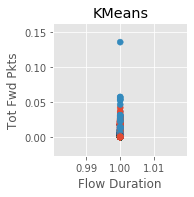

/home/riz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


CPU times: user 16.5 s, sys: 19.2 s, total: 35.8 s
Wall time: 8.51 s


In [35]:
%%time 

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
#     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 3} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 3} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
#     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 1
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'white' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

#     for j in range(3):
#         plt.subplot(rows,columns,i*columns+1+j+1)
#         plt.scatter(*(projections[j].T), c=colors) 
#         plt.xlabel('x'), plt.ylabel('y')
#         plt.title('TSNE projection '+str(j+1),size=12)
        
#     break

# plt.suptitle('Comparison of botnet Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])

plt.show()

botnet_w_classes = train.copy()
botnet_w_classes['Label'] = labels

botnet_w_classes['Label'].to_csv(DATA_SET_PATH + 'class_labels.csv')

# plt.savefig('botnet_Cluster_Diagram.png')

<a id="GAN setup"><h1>GAN setup and training</h1></a>

<a href='#TOC'>Table of contents</a>


Resources:

https://github.com/wayaai/GAN-Sandbox
<br>
http://blog.richardweiss.org/2017/07/21/conditional-wasserstein-gan.html



Conversion of Waya.ai GAN and WGAN
- Remove convolutional layers
- Remove ResNeXt
- Add simple dense networks
- Convert WGAN back to simple GAN
- Use common functions as much as possible


In [36]:
botnet_w_classes_reindexed = botnet_w_classes.reset_index(drop=True)

In [42]:
import gan
import importlib
importlib.reload(gan) # For reloading after making changes
from gan import *


# botnet_w_classes_reindexed = train.copy().reset_index(drop=True)
# botnet_w_classes_reindexed = botnet_w_classes.reset_index(drop=True)
# ----------------------------------------------------------------------------------------------------------------------------------------------------
# for i in [1024, 2048]:
for i in [16*1024]: #7105
# for i in [113680]:
    if i > 128: 
        device = "/gpu:2"
    else: 
        device = "/cpu"
        
    print("----------------------------")
    print("Device Selected: " + device)
    print("----------------------------")
    batch_size =  i
    # ------------------------------------------------adding more rows to training data from last rows of training data equal to remainder rows-----------
    remaining = botnet_w_classes_reindexed.shape[0] % batch_size
    
    print(remaining)
    
    print(botnet_w_classes_reindexed.shape[0])
    
    if remaining < botnet_w_classes_reindexed.shape[0]:
        bwcr_additional = botnet_w_classes_reindexed.loc[botnet_w_classes_reindexed.shape[0] - remaining:botnet_w_classes_reindexed.shape[0],: ]    
        frames = [botnet_w_classes_reindexed, bwcr_additional]
        result = pd.concat(frames)
        result = result.reset_index(drop=True)

        print(result.shape)

    else:
        result = botnet_w_classes

#     result = botnet_w_classes_reindexed
    # ----------------------------------------------------------------------------------------------------------------------------------------------------
    base_n_count = 128
    required_epochs = 5000
    # ----------------------------------------------------------------------------------------------------------------------------------------------------
    TRAINING_ITERATIONS = required_epochs * result.shape[0] // batch_size
    
    log_interval = result.shape[0] // batch_size # We are setting this as an epoch. This depends on data size.
#     log_interval = 100#result.shape[0]// batch_size # test after every epoch
    
    nb_steps = TRAINING_ITERATIONS  # 50000 # Add one for logging of the last interval
    print("Total Batch Iterations: " + str(nb_steps))
    
    # rand_dim = len(data_cols) + 1 #51 # 32 # needs to be ~data_dim
    rand_dim = result.shape[1] 


    k_d = 1  # number of critic network updates per adversarial training step
    k_g = 1  # number of generator network updates per adversarial training step

    critic_pre_train_steps = 100# 100  # number of steps to pre-train the critic before starting adversarial training
#     log_interval = train.shape[0] // batch_size # We are setting this as an epoch. This depends on data size.

    
    generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

#     show = False
    show = True 

    # train = create_toy_spiral_df(1000)
    # train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
    train = result#.copy().reset_index(drop=True) # botnet only with labels from classification
    
#     test_size = batch_size
    # train = data # only the botnet data with IP labelling from ISCX botnet dataset
    # train = pd.get_dummies(train, columns=['Label'], prefix='Label', drop_first=True)
    label_cols = [ i for i in train.columns if 'Label' in i ]
    data_cols = [ i for i in train.columns if i not in label_cols ]

    print("data_cols = " + str(len(data_cols)))
    train[ data_cols ] = train[ data_cols ] # scale to random noise size, one less thing to learn
    train_no_label = train[ data_cols ]
    
#     print(train['Label'])


#     loss_pickle_path = 0
#     generator_model_path = 0    
#     discriminator_model_path = 0
    
    test_size = train.shape[0] 
    
    print('test size: ' + str(test_size))

----------------------------
Device Selected: /gpu:2
----------------------------
15376
113680
(129056, 65)
Total Batch Iterations: 39384
data_cols = 64
test size: 129056


In [43]:
# %%time

# # Training the vanilla GAN and CGAN architectures

# k_d = 1  # number of discriminator network updates per adversarial training step
# learning_rate = 1e-2 # 5e-5

# CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-cache/GAN/'
# FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/GAN/'


# data_dir = CACHE_PATH


# arguments = [rand_dim, nb_steps, batch_size, 
#              k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
#             data_dir, FIGS_PATH, generator_model_path, discriminator_model_path, loss_pickle_path, show, test_size, device]


# adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN

In [44]:
# %%time

# # Training the vanilla GAN and CGAN architectures

# k_d = 1  # number of discriminator network updates per adversarial training step
# learning_rate = 1e-2 # 5e-5

# CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-cache/CGAN/'
# FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/CGAN/'

# data_dir = CACHE_PATH


# arguments = [rand_dim, nb_steps, batch_size, 
#              k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
#             data_dir, FIGS_PATH, generator_model_path, discriminator_model_path, loss_pickle_path, show, test_size, device ]

# adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

In [ ]:
%%time

k_d = 1 # train critic to optimal state each time
learning_rate = 1e-2 # 5e-5

tf.compat.v1.disable_eager_execution()

CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-cache/WGAN/'
FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/WGAN/'

data_dir = CACHE_PATH

arguments =[rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, FIGS_PATH, generator_model_path, discriminator_model_path, loss_pickle_path, show, test_size, device ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN

data_dim:  64
data_cols:  ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Act

[]
Time taken so far: 26111.21325778961 seconds
Time left = 988.07 hours
[]
Time taken so far: 26608.509380817413 seconds
Time left = 982.73 hours
[]
Time taken so far: 27475.7054874897 seconds
Time left = 990.99 hours
[]
Time taken so far: 28154.700926303864 seconds
Time left = 992.22 hours
[]
Time taken so far: 28732.57775735855 seconds
Time left = 989.91 hours
[]
Time taken so far: 29427.72175526619 seconds
Time left = 991.64 hours
[]
Time taken so far: 30172.09010910988 seconds
Time left = 994.91 hours
[]
Time taken so far: 30924.8337290287 seconds
Time left = 998.31 hours
[]
Time taken so far: 31366.84906077385 seconds
Time left = 991.73 hours
[]
Time taken so far: 32038.043255329132 seconds
Time left = 992.52 hours
[]
Time taken so far: 33065.45801091194 seconds
Time left = 1004.08 hours
[]
Time taken so far: 33727.93621015549 seconds
Time left = 1004.32 hours
[]
Time taken so far: 34427.79276776314 seconds
Time left = 1005.64 hours
[]
Time taken so far: 35104.68199276924 seconds

data_dim:  64
data_cols:  ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Act

FileNotFoundError: [Errno 2] No such file or directory: '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/WCGAN/Probability Density Functions-0.svg'

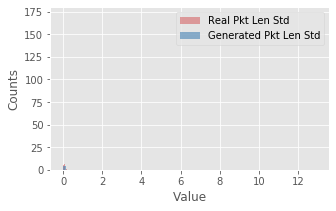

In [41]:
%%time

k_d = 1 # train critic to optimal state each time
learning_rate = 1e-2 # 5e-5

CACHE_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-cache/WCGAN/'
FIGS_PATH = '/media/riz/3a021e04-b2b0-43ed-a7dc-4fab8a1ca9dd/rizwan/full_dataset/jupyter-figs/WCGAN/'

data_dir = CACHE_PATH

arguments =[rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, FIGS_PATH, generator_model_path, discriminator_model_path, loss_pickle_path, show, test_size, device ]



adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN